# Stock Price Forecasting

This notebook contains: data loading, preprocessing, ARIMA (statsmodels), LSTM (Keras), Prophet, rolling-window evaluation, performance table, and how to save and prepare models for upload to Hugging Face Hub.

**Use the included `sample_stock.csv` if you don't have internet access.**

In [ ]:
# Install missing packages (uncomment and run if needed)
# !pip install -r requirements.txt


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# helper metrics
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-8, y_true))) * 100

print('Ready')

Ready


In [2]:
# Load data: either download via yfinance or use sample CSV
USE_YFINANCE = False
if USE_YFINANCE:
    import yfinance as yf
    df = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
    df = df.reset_index()[['Date','Close']]
else:
    df = pd.read_csv('sample_stock.csv', parse_dates=['Date'])

print(df.shape)
df.head()

(523, 2)


Date       Close
0 2020-01-01  100.546714
1 2020-01-02  100.458450
2 2020-01-03  101.156138
3 2020-01-06  102.729168
4 2020-01-07  102.545015

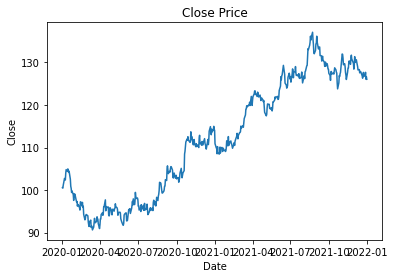

In [3]:
# Basic preprocessing
df = df.sort_values('Date').reset_index(drop=True)
df['Close'] = df['Close'].astype(float)
plt.plot(df['Date'], df['Close'])
plt.title('Close Price'); plt.xlabel('Date'); plt.ylabel('Close')
plt.show()

## ARIMA (statsmodels)
We will fit a simple ARIMA model on the training set and forecast a short horizon.

C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  418
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -572.240
Date:                Thu, 02 Oct 2025   AIC                           1156.479
Time:                        16:43:47   BIC                           1180.678
Sample:                    01-01-2020   HQIC                          1166.046
                         - 08-06-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0465      0.051     -0.910      0.363      -0.147       0.054
ar.L2         -0.0160      0.051     -0.312      0.755      -0.116       0.084
ar.L3          0.0122      0.050      0.244      0.8

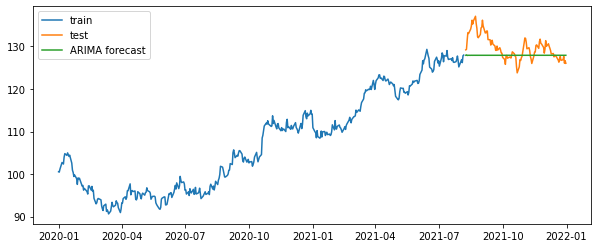

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare series
series = df.set_index('Date')['Close']
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit a simple ARIMA(5,1,0) as example (tune for your data)
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Forecast
n_forecast = len(test)
fc = model_arima_fit.forecast(steps=n_forecast)
rmse_arima = sqrt(mean_squared_error(test, fc))
mape_arima = mape(test, fc)
print(f'ARIMA RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.4f}%')

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, fc, label='ARIMA forecast')
plt.legend(); plt.show()

## Prophet
Example usage. Prophet works with a dataframe of columns `ds` (date) and `y` (value).

16:44:17 - cmdstanpy - INFO - Chain [1] start processing
16:44:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 4.7530, MAPE: 3.1763%


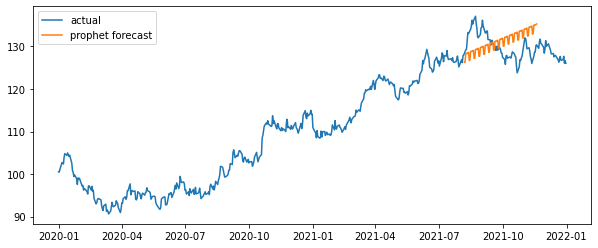

In [5]:
try:
    from prophet import Prophet
    prop = Prophet()
    df_prop = df.rename(columns={'Date':'ds','Close':'y'})[['ds','y']]
    train_prop = df_prop.iloc[:train_size]
    test_prop = df_prop.iloc[train_size:]
    prop.fit(train_prop)
    future = prop.make_future_dataframe(periods=len(test))
    forecast = prop.predict(future)
    fc_prop = forecast.set_index('ds')['yhat'].iloc[-len(test):]
    rmse_prop = sqrt(mean_squared_error(test_prop['y'].values, fc_prop.values))
    mape_prop = mape(test_prop['y'].values, fc_prop.values)
    print(f'Prophet RMSE: {rmse_prop:.4f}, MAPE: {mape_prop:.4f}%')
    
    plt.figure(figsize=(10,4))
    plt.plot(df['Date'], df['Close'], label='actual')
    plt.plot(fc_prop.index, fc_prop.values, label='prophet forecast')
    plt.legend(); plt.show()
except Exception as e:
    print('Prophet may not be installed or failed to run:', e)


## LSTM (Keras)
We'll create a simple LSTM that uses a sliding window of past `seq_len` days to predict the next day.
Note: For realistic results train longer and use more data; here we keep it short for demo.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

series_values = series.values.reshape(-1,1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_values)

# prepare sequences
seq_len = 10
X, y = [], []
for i in range(len(series_scaled) - seq_len):
    X.append(series_scaled[i:i+seq_len, 0])
    y.append(series_scaled[i+seq_len, 0])
X = np.array(X); y = np.array(y)

# split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# build model
model_lstm = Sequential([LSTM(32, input_shape=(seq_len,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1, callbacks=[es], verbose=1)

# predict
pred_scaled = model_lstm.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_lstm = sqrt(mean_squared_error(true, pred))
mape_lstm = mape(true, pred)
print(f'LSTM RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.4f}%')

plt.figure(figsize=(10,4))
plt.plot(range(len(true)), true, label='true')
plt.plot(range(len(pred)), pred, label='pred')
plt.legend(); plt.show()

# Save model and scaler for deployment
try:
    model_lstm.save('lstm_model.h5')
    import joblib
    joblib.dump(scaler, 'scaler.pkl')
    print('Saved lstm_model.h5 and scaler.pkl')
except Exception as e:
    print('Failed to save model (check environment):', e)


ImportError: Traceback (most recent call last):
  File "C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

## Rolling-window evaluation (walk-forward)
We compute rolling-window forecasts (one-step ahead) and aggregate RMSE/MAPE for each model.

In [ ]:
def rolling_forecast_arima(series, window=200):
    from statsmodels.tsa.arima.model import ARIMA
    preds = []
    for i in range(window, len(series)):
        train = series[:i]
        try:
            model = ARIMA(train, order=(5,1,0)).fit()
            p = model.forecast(steps=1)[0]
        except Exception:
            p = train.iloc[-1]
        preds.append(p)
    return np.array(preds)

# small rolling demo (may be slow on long series)
window = min(200, len(series)-2)
roll_preds = rolling_forecast_arima(series, window=window)
roll_true = series[window:]
rmse_roll = sqrt(mean_squared_error(roll_true, roll_preds))
print('Rolling-window ARIMA RMSE:', rmse_roll)


C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\supereme\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\supereme\AppData\Local\Temp\ipykernel_12640\1435293311.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

In [ ]:
# Performance summary table
summary = pd.DataFrame([{ 'Model':'ARIMA', 'RMSE': rmse_arima, 'MAPE': mape_arima },
                         { 'Model':'Prophet', 'RMSE': locals().get('rmse_prop', np.nan), 'MAPE': locals().get('mape_prop', np.nan)},
                         { 'Model':'LSTM', 'RMSE': rmse_lstm, 'MAPE': mape_lstm }])
summary

# Save summary
summary.to_csv('performance_summary.csv', index=False)
print('Saved performance_summary.csv')

## Next steps / Deployment
- Use `upload_to_hf.py` to push `lstm_model.h5`, `scaler.pkl`, and `performance_summary.csv` to Hugging Face Hub repository `username/DataSynthis_ML_JobTask`.
- Provide a `README.md` in the HF repo describing how to use the model to make predictions.
